In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)
import shared_utils

from calitp.tables import tbls
from calitp import query_sql
import calitp.magics

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt

import importlib
from rt_analysis import rt_filter_map_plot

from IPython.display import display, Markdown, Latex, HTML
import json

In [2]:
## parameters cell
itp_id = 300

In [3]:
analysis_date = dt.date(2022, 10, 12)

In [4]:
%%capture
rt_day = rt_filter_map_plot.from_gcs(itp_id, analysis_date)

# Big Blue Bus

## About These Maps:

* Each map shows bus (and rail, if applicable) speeds for Big Blue Bus
* On the map, routes are split into segments corresponding to the distance between two stops, allowing you to focus on specific portions of the route experiencing a slowdown.
* Route segments are arrow-shaped to indicate direction of travel.
* Hover over, or click, a segment with your mouse to see the exact speed, route name, and transit service frequency in that segment. 
    * Higher-frequency routes (3+ trips per hour) are especially important, since those slowdowns correspond to more vehicles, and riders, delayed in traffic.

In [5]:
rt_day.rt_trips.route_short_name.unique()

array(['R12', '9', '14', '3', '1', '8', '7', 'R7', '2', '16', '17', '41',
       '18', '43', 'R10', 'R3', '5', '15'], dtype=object)

In [6]:
lincoln_rts = ['3', 'R3']

## Afternoon Peak


In [7]:
%%capture
rt_day.set_filter(start_time='15:00', end_time='19:00', route_names=['R3'])

In [8]:
# rt_day.set_filter(start_time='15:00', end_time='19:00', route_names=['3'])

In [9]:
## avoid papermill errors when map fails to render
m = None

In [10]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds')

In [11]:
m

In [12]:
m = rt_day.segment_speed_map(how='average')

In [13]:
m

In [14]:
rt_day.rt_trips.direction = rt_day.rt_trips.direction.map(lambda x: 'Eastbound' if x =='Southbound' else x) # rename partial data trip to match

In [15]:
(rt_day._filter(rt_day.rt_trips)
 >> group_by(_.route_short_name, _.shape_id, _.direction)
 >> summarize(mean_mph = _.mean_speed_mph.mean())
)

,route_short_name,shape_id,direction,mean_mph
0,R3,26031,Westbound,12.782654
1,R3,26032,Eastbound,8.739125


# Initial Thoughts

* Rapid 3 often slower than standard 3
* Rapid 3 not currently using Lincoln Blvd S of Manchester, routing is Manchester to Sepulveda
    * Previous iterations of route did -- unsure if change was due to congestion or desire to serve destinations along Manchester and the LAX City Bus Center
    * This new routing also seems to better serve the future LAX Airport Metro Connector
    * Let's assume the new routing for this analysis -- these segments have fairly high speeds anyhow
* No bus lanes installed on SHN portion yet (existing lane in City of Santa Monica only)

## Speedmap Interpretation (PM Peak)

* _29 minutes_ for the average R3 trip to travel 1.5 miles from Broadway Street, past Venice Bl, to SR90
    * at the 20th percentile for each segment, over 45 minutes to go that same distance!
    
## Corridor Delay Interpretation

* Define corridor as Ozone to Manchester, starting at beginning of SHN portion and ending where BBB 3/R3 routes diverge
* Weekday average schedule delay is _400 minutes_, weekday average speed-based delay is _1226 minutes_
* If bus lanes achieve 16mph average, a speed already exceeded on less congested parts of route, riders would save 20 hours per day _and_ Big Blue Bus would be able to add 20 additional trips with the same number of operating hours - further improving the rider experience and reducing travel times

In [16]:
rt_day.set_filter(start_time='15:00', end_time='19:00', route_names=lincoln_rts, shape_ids=['26032'])

Text(0.5, 1.0, 'Big Blue Bus Speed Variability by Stop Segment, All Route Types, Route(s) R3, Eastbound, PM Peak, Oct 12 (Wed)')

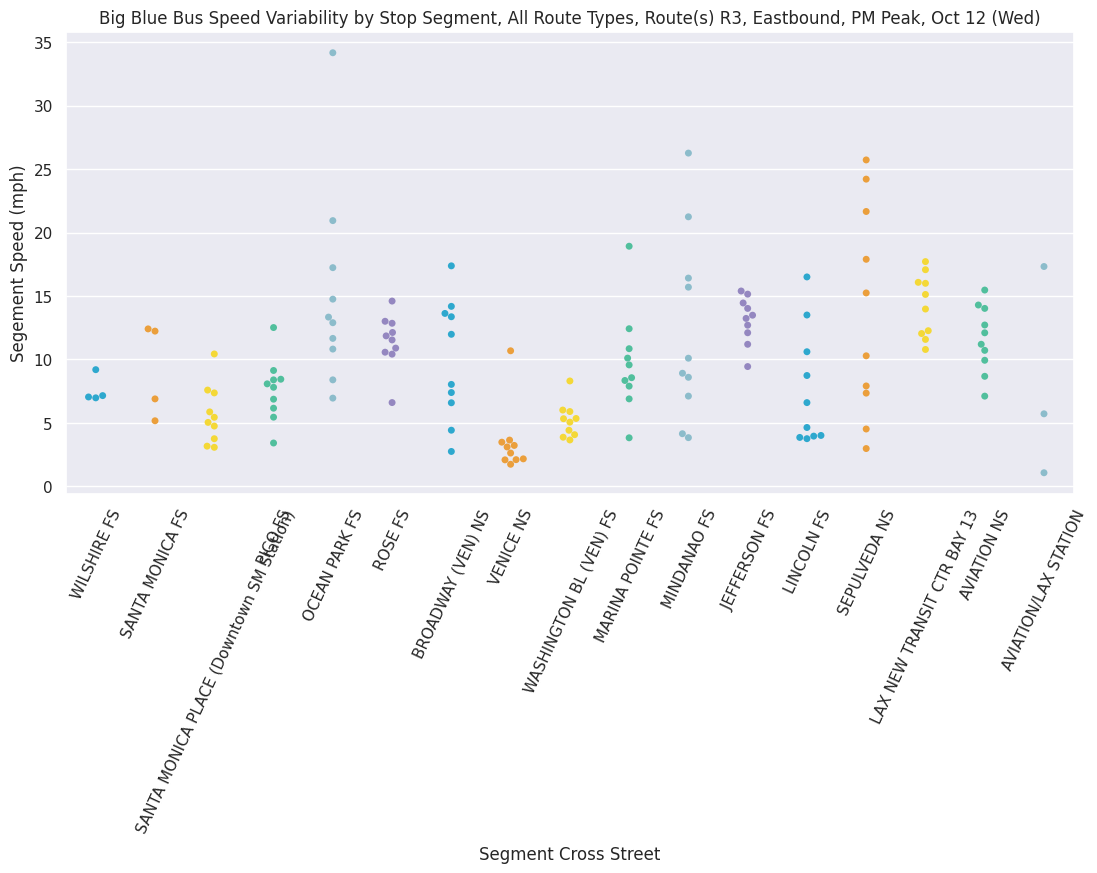

In [17]:
rt_day.chart_variability()

In [18]:
rt_day.set_filter(start_time='15:00', end_time='19:00', route_names=lincoln_rts, shape_ids=['26031'])

Text(0.5, 1.0, 'Big Blue Bus Speed Variability by Stop Segment, All Route Types, Route(s) R3, Westbound, PM Peak, Oct 12 (Wed)')

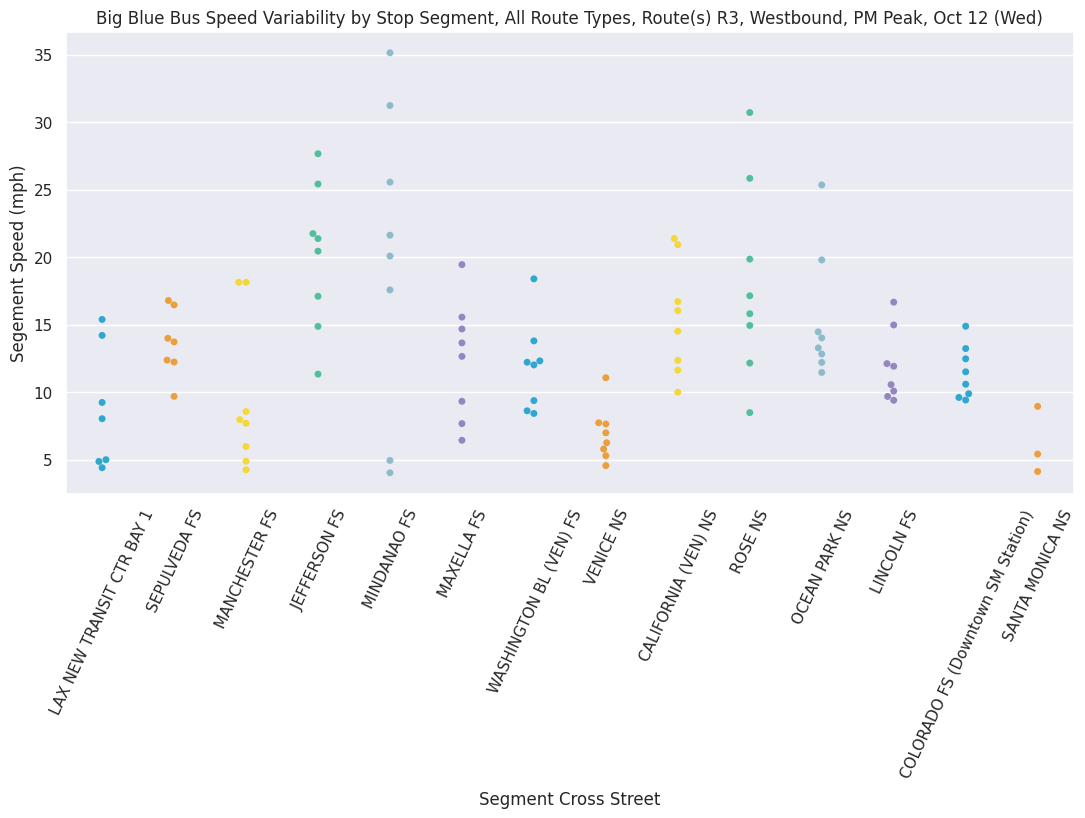

In [19]:
rt_day.chart_variability()

# Corridor Delay

In [20]:
corridor = gpd.read_file('./corridors_100buses/lincoln_ozone_manchester.geojson')

In [21]:
sub_corridor = gpd.read_file('./corridors_100buses/lincoln_ozone_lucille.geojson')

In [22]:
rt_day.add_corridor(corridor)

In [23]:
rt_day.quick_map_corridor()

In [24]:
rt_day.add_corridor(sub_corridor)

In [25]:
rt_day.quick_map_corridor()

In [26]:
rt_day.set_filter(route_names=lincoln_rts)

In [27]:
rt_day.corridor_metrics()

{'schedule_metric_minutes': -86.10833333333333,
 'speed_metric_minutes': 355.5669697223368}

In [28]:
rt_day._filter(rt_day.endpoint_delay_view).delay_seconds.median()

308.0

In [29]:
890/60

14.833333333333334

## Averaged Metrics

In [30]:
import numpy as np
from tqdm.notebook import tqdm

In [31]:
full_wk = np.arange('2022-10-08', '2022-10-15', dtype='datetime64[D]') # 7-day week

In [32]:
weekdays = np.arange('2022-10-10', '2022-10-15', dtype='datetime64[D]') # weekdays

In [33]:
from rt_analysis.sccp_tools import sccp_average_metrics

In [34]:
sccp_average_metrics?

Signature:
sccp_average_metrics(
    itp_id: int,
    date_range: <built-in function arange>,
    corridor: geopandas.geodataframe.GeoDataFrame,
    filter_dict: dict = None,
)
Docstring:
Generate averaged corridor delay metrics for SCCP, LPP programs. For 2022-2023 cycle,
default range is Apr 30 2022 to May 8 2022:
date_range = np.arange('2022-04-30', '2022-05-09', dtype='datetime64[D]')

Optional filter_dict should _not_ be used to generate SCCP/LPP metrics, but is available
for exploratory analysis and other analyses. Supply RtFilterMapper.set_filter params
as dict keys with each param's value as dict values:
filter_dict = {'start_time': '06:00', 'end_time': '10:00', 'route_names': ['2', 'R12']}
File:      ~/data-analyses/rt_delay/rt_analysis/sccp_tools.py
Type:      function


In [35]:
full_metrics = sccp_average_metrics(300, weekdays, corridor)

found parquet
complete for date: 2022-10-10
found parquet
complete for date: 2022-10-11
found parquet
complete for date: 2022-10-12
found parquet
complete for date: 2022-10-13
found parquet
complete for date: 2022-10-14


In [36]:
full_metrics

{'avg_schedule_metric_minutes': 410.0,
 'avg_speed_metric_minutes': 1222.0,
 'all_schedule': [110.825, 203.35, 592.6916666666667, 897.275, 244.725],
 'all_speed': [643.9043498805323,
  904.9579915065725,
  1212.2713476963506,
  2173.6312977845328,
  1172.9459344590805]}

In [37]:
sub_metrics = sccp_average_metrics(300, weekdays, sub_corridor)

found parquet
complete for date: 2022-10-10
found parquet
complete for date: 2022-10-11
found parquet
complete for date: 2022-10-12
found parquet
complete for date: 2022-10-13
found parquet
complete for date: 2022-10-14


In [38]:
sub_metrics

{'avg_schedule_metric_minutes': -86.0,
 'avg_speed_metric_minutes': 350.0,
 'all_schedule': [-64.25,
  -83.925,
  -86.10833333333333,
  -132.16666666666666,
  -61.75833333333333],
 'all_speed': [293.7372926125506,
  310.7564030099008,
  355.5669697223368,
  367.67100671275136,
  421.6931689272872]}

## What about midday? 

In [46]:
rt_day.analysis_date

datetime.date(2022, 10, 12)

In [47]:
rt_day.set_filter(start_time='09:00', end_time='16:00', route_names=['3', 'R3'])

In [48]:
m = rt_day.segment_speed_map(how='average')

In [49]:
m

In [43]:
filter_dict = {'start_time': '09:00', 'end_time': '16:00'}

In [44]:
midday_delay = sccp_average_metrics(300, weekdays, corridor, filter_dict)

found parquet
complete for date: 2022-10-10
found parquet
complete for date: 2022-10-11
found parquet
complete for date: 2022-10-12
found parquet
complete for date: 2022-10-13
found parquet
complete for date: 2022-10-14


In [45]:
midday_delay

{'avg_schedule_metric_minutes': 176.0,
 'avg_speed_metric_minutes': 660.0,
 'all_schedule': [61.69166666666667,
  80.81666666666666,
  353.7416666666667,
  278.7583333333333,
  105.66666666666667],
 'all_speed': [337.3091795918404,
  482.83350032934607,
  693.4949589398834,
  1146.7261159725847,
  638.9238168150727]}